In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [2]:
#a) Load the oxford_iiit_pet dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTBCIKJ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTBCIKJ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
def read_and_preprocess(data):
  input_image = tf.image.resize(data['image'], (128,128))    #Resize the data['image'] to 128x128
  input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))    #Resize the data['segmentation_mask'] to 128x128

  input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
  input_mask -= 1 # {1,2,3} to {0,1,2}

  return input_image, input_mask

In [4]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

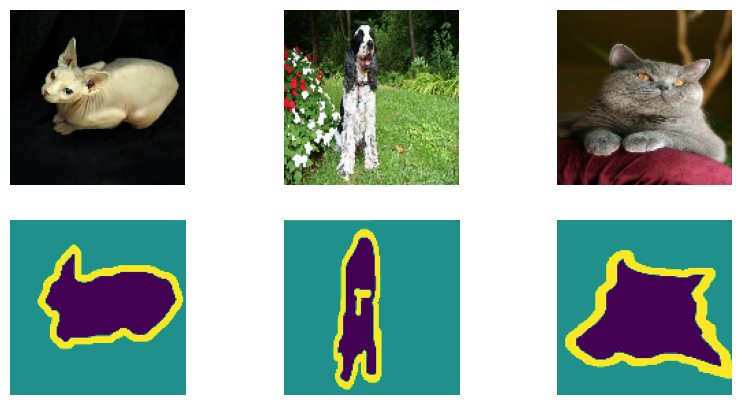

In [5]:
# b) Create the segmentation mask
# Show some images from dataset and their segmented version
fig, ax = plt.subplots(2, 3, figsize = (10,5))
for i,(img, mask) in enumerate(train.take(3)):
    ax[0, i].imshow(tf.keras.preprocessing.image.array_to_img(img))
    ax[0, i].axis('off')
    mask = tf.reshape(mask, [128,128])
    ax[1, i].imshow(mask.numpy())
    ax[1, i].axis('off')

**Part 2- Annotation**

In [6]:
# Install mrcnn
!pip install mrcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54907 sha256=d5772ea3767042024182e254260240b26ee5a21fa20b9575e952c9aae862f912
  Stored in directory: /root/.cache/pip/wheels/f6/66/35/4956a489776a1db0ee24e0c33a9088c1b5d68eb5dc2654f0b2
Successfully built mrcnn


In [7]:
# Get data from here https://github.com/experiencor/raccoon_dataset
!wget https://github.com/experiencor/raccoon_dataset/archive/refs/heads/master.zip
!unzip /content/master.zip

--2023-11-10 19:54:57--  https://github.com/experiencor/raccoon_dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/experiencor/raccoon_dataset/zip/refs/heads/master [following]
--2023-11-10 19:54:58--  https://codeload.github.com/experiencor/raccoon_dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [               <=>  ]  46.98M  13.6MB/s    in 3.5s    

2023-11-10 19:55:01 (13.6 MB/s) - ‘master.zip’ saved [49258753]

Archive:  /content/master.zip
27f269ab4d4da6c38ebb16b4a95c5c912a9f1c49
   creating: raccoon_dataset-maste

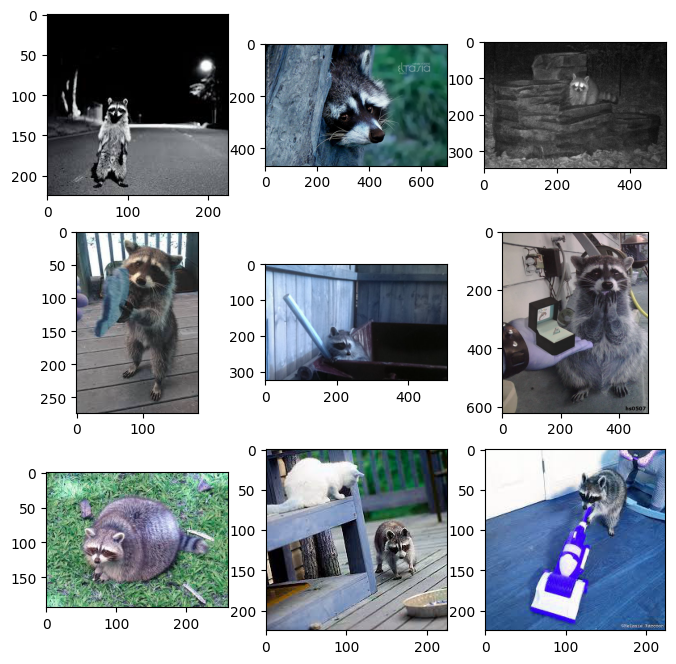

In [8]:
# Look into data
# Plot some samples here
import glob
data_dir = '/content/raccoon_dataset-master/images'
images = glob.glob(data_dir + '/*.jpg')
plt.figure(figsize=(8, 8))

for i in range(9):
  img = cv2.imread(str(images[i]))
  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
plt.show()

In [10]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("raccoon_dataset", 1, "raccoon")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/raccoon-'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[8:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		#path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   #Added by me
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('raccoon'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset-master', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset-master', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 149
Test: 51


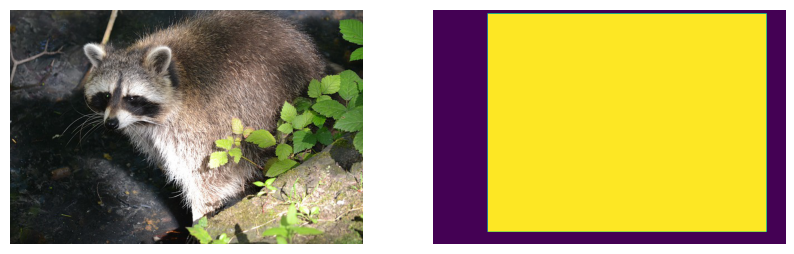

In [11]:
# load an image
# Use the function above to create the image and its mask
img_no = 124
norm_img = train_set.image_reference(img_no)
mask_img,masks = train_set.load_mask(img_no)
img_norm = cv2.imread(str(norm_img))
RGB_img_norm = cv2.cvtColor(img_norm, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].imshow(RGB_img_norm)
ax[0].axis('off')
ax[1].imshow(mask_img)
ax[1].axis('off')
plt.show()

**Part 3- YOLO 8**




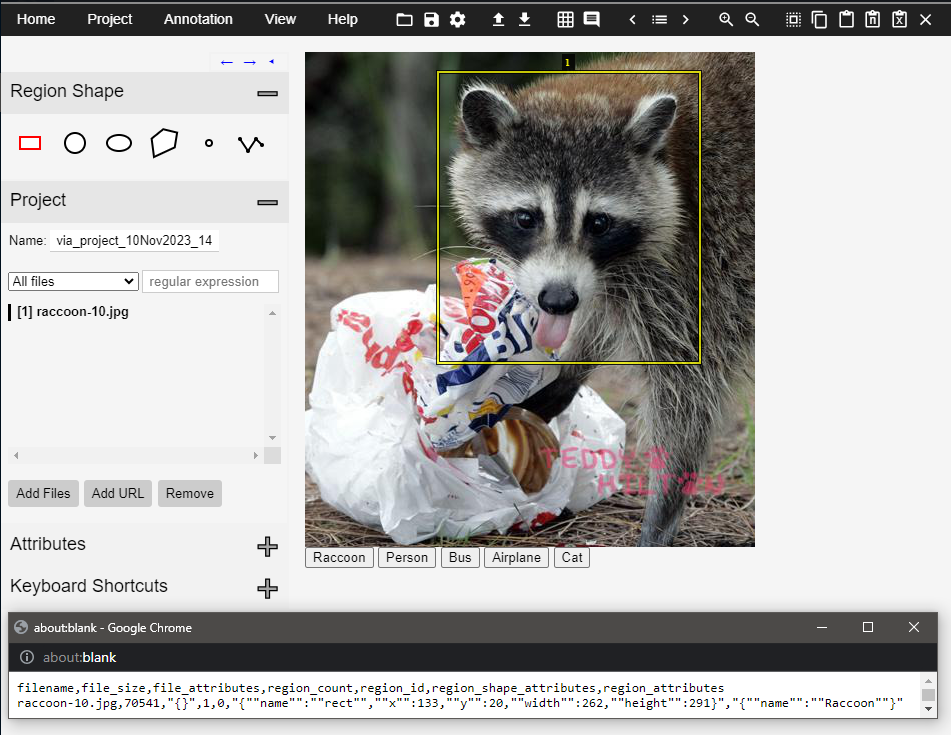

In [2]:
# a- Create annotation
# You can upload the file using ![title](filename.jpeg)
# import image module
from IPython.display import Image
Image(filename='/content/Annotation.PNG',width=600)

In [3]:
#b- Now, we want to install Yolo8.
# Download required tools
# Clone yolo 8 and check all dependencies
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.4/78.2 GB disk)


In [5]:
#c- Train the model here
# Follow the Github instruction to train a YOLO8 model here
from ultralytics import YOLO
model = YOLO("yolov8n.yaml")
model = YOLO("yolov8n.pt")
model.train(data="coco128.yaml", epochs=3)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78b90704b0a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,

In [6]:
#d- Test model
#Import ultralytics
# Test this above trained model on an image. For example: https://ultralytics.com/images/bus.jpg
metrics = model.val()
results = model(source="https://ultralytics.com/images/bus.jpg",save=True, save_txt=True)
# path = model.export(format="onnx")

Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                   all        128        929      0.665      0.546      0.625      0.463
                person        128        254      0.803      0.675      0.775      0.554
               bicycle        128          6      0.579      0.333      0.319      0.281
                   car        128         46      0.717      0.217      0.276      0.182
            motorcycle        128          5      0.828      0.967      0.928      0.737
              airplane        128          6      0.681      0.667      0.913      0.692
                 

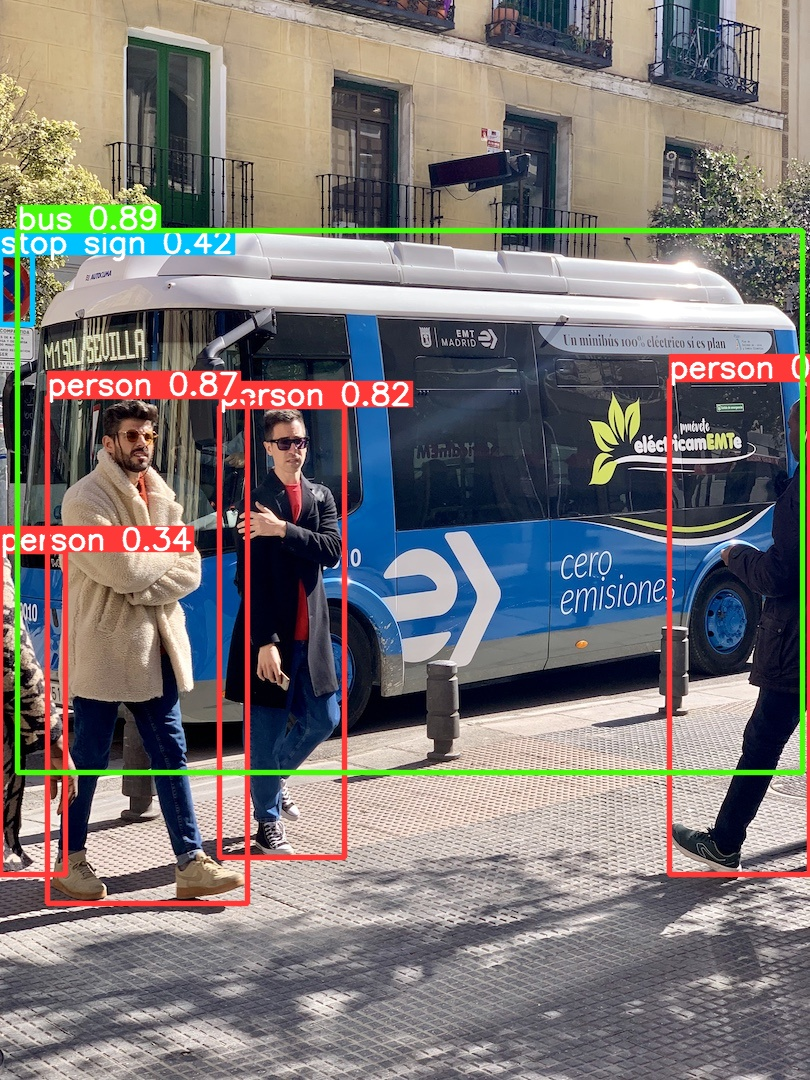

In [8]:
# e- See the result.
# Show the result and all the assigned objects here
Image(filename='/content/runs/detect/train23/bus.jpg',width=600)

In [10]:
# What is your understanding from this image? What is the meaning of these numbers all over the image?

This image illustrates all the objects that the model recognized (people, bus, and a stop sign). The numbers are the corresponding confidence level that there is an object within that bounding box.